# Testing of queue imbalance for company 9095

Order of this notebook is as follows:
1. [Data preparation](#Data-preparation)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [1](#Resources).

In [1]:
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
import lob

import warnings

warnings.filterwarnings('ignore')

## Data preparation

The data seems to be from small-tick market.

### Train data

For training data we used data from 2013-09 - 2013-10:

* 0901
* 0916
* 1001
* 1016

### Test data

For testing data we used data from first half of 2013-11

* 1101

In [2]:
df, df_test = lob.load_data('9065')
df.head()

Training set length: 15489
Testing set length: 3862


,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-02 05:01:00,"[(1000.0, 5000.0), (1110.0, 2625.0), (1200.0, ...","[(1699.0, 100.0), (1712.0, 4000.0), (1740.0, 2...",1630.0,1699.0,1664.5,100.0,150.0,0,0.200000
2013-09-02 07:51:00,"[(980.0, 500.0), (1000.0, 6000.0), (1110.0, 26...","[(1655.0, 300.0), (1665.0, 300.0), (1674.0, 40...",1637.0,1655.0,1646.0,300.0,1500.0,0,0.666667
2013-09-02 07:52:00,"[(980.0, 500.0), (1000.0, 6000.0), (1110.0, 26...","[(1654.0, 2210.0), (1655.0, 300.0), (1665.0, 3...",1637.0,1654.0,1645.5,2210.0,6710.0,0,0.504484
2013-09-02 07:53:00,"[(980.0, 500.0), (1000.0, 6000.0), (1110.0, 26...","[(1650.0, 150.0), (1654.0, 3210.0), (1655.0, 3...",1650.0,1650.0,1650.0,150.0,1250.0,1,0.785714
2013-09-02 07:54:00,"[(980.0, 500.0), (1000.0, 6000.0), (1110.0, 26...","[(1613.0, 3856.0), (1650.0, 150.0), (1654.0, 3...",1650.0,1613.0,1631.5,3856.0,1250.0,0,-0.510380


## Data visualization

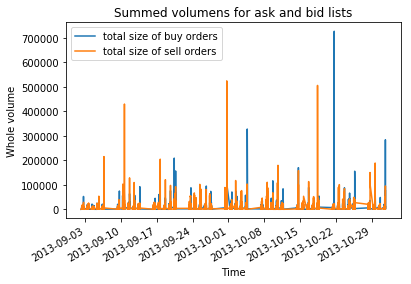

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders')
df['sum_sell_ask'].plot(label='total size of sell orders')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

Text(0,0.5,'Price')

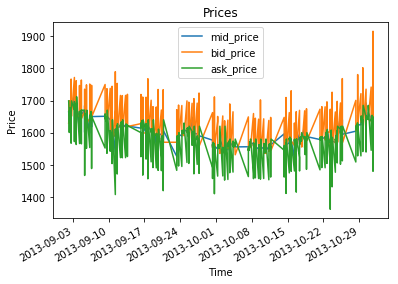

In [4]:
df[['mid_price', 'bid_price', 'ask_price']].plot()
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

Text(0.5,1,'Queue imbalance vs mid price indicator for a few records')

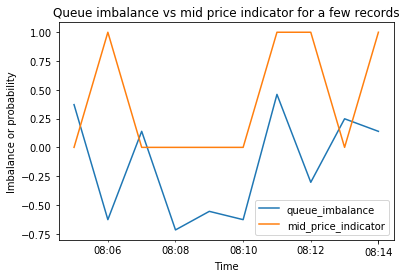

In [5]:
df.iloc[10:20][['queue_imbalance', 'mid_price_indicator']].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Imbalance or probability')
plt.title('Queue imbalance vs mid price indicator for a few records')

Text(0.5,1,'Mid price indicator density')

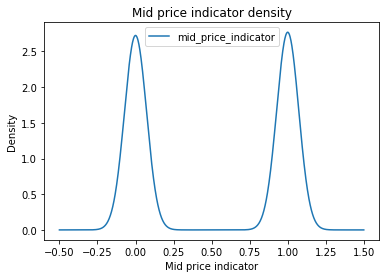

In [6]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

Text(0.5,1,'Queue imbalance density')

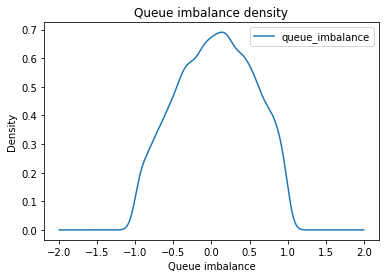

In [7]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`.

[0.00029208015900546565, 0.24963535224726074, 0.25, 0.4875712066286898]


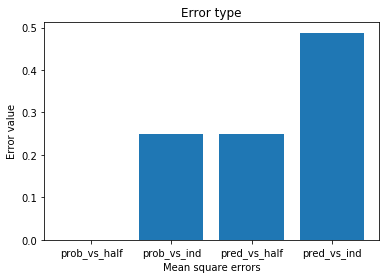

In [8]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df_test['mid_price_indicator'] - predictions) ** 2).mean()

plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')
print([prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])

Text(0,0.5,'Prediction')

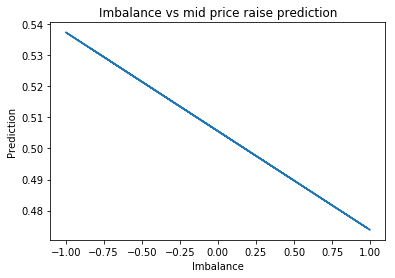

In [9]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Imbalance vs mid price raise prediction')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

Text(0,0.5,'Mid price prediction')

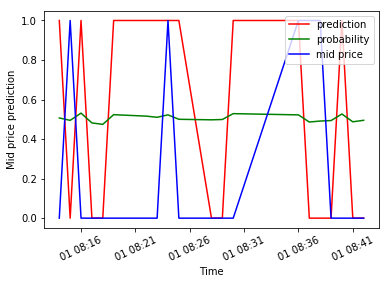

In [10]:
st = 10
end = 30

plt.plot(df_test.index[st:end], predictions[st:end], 'r', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - it looks like normal distribution: most often the queues are balanced.

Errors:

* predicted probability vs null model: 0.00029
* predicted probability vs known indicator: 0.24963
* prediction vs null model: 0.25
* prediction vs known indicator: 0.48

Probabilistic classification works about 25% better than null model. Its values are between 0.47-0.54, which is the reason of why mean square error between probabilistic predictions and null model is small (0.00029). 
Binary classification works about 2% better than null model.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 